# ARIMAモデル

- とりあえず、ある店舗についてARIMAモデルを適用してみる

In [87]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import AR, ARMA, ARIMA
from IPython.display import  display
sns.set_style('whitegrid')
%matplotlib inline

## データの取得

In [88]:
features_format = pd.read_csv('../data/features_format.csv', engine='python')

In [89]:
features_format['visit_date'] = pd.to_datetime(features_format['visit_date'])
features_format.dtypes

air_store_id            object
visit_date      datetime64[ns]
visitors               float64
dtype: object

In [90]:
# 期間中に欠損のない店舗を見つける
# だが、そんな店舗はなかった
is_open_everyday = features_format.groupby('air_store_id').apply(lambda x : x.isnull().any(axis=0).visitors)
is_open_everyday[is_open_everyday ==  False]

Series([], dtype: bool)

In [91]:
# 期間中に最もレコードの多い店舗は？
num_of_opne_day = features_format.groupby('air_store_id').apply(lambda x : x.count().visitors)
num_of_opne_day.sort_values(ascending=False).head()

air_store_id
air_5c817ef28f236bdf    438
air_a083834e7ffe187e    438
air_36bcf77d3382d36e    437
air_d97dabf7aae60da5    437
air_232dcee6f7c51d37    436
dtype: int64

## "air_5c817ef28f236bdf"というお店の来客予測を行う
air_5c817ef28f236bdf は渋谷にある居酒屋らしい

In [92]:
train_data = features_format.query('air_store_id == "air_5c817ef28f236bdf"')[['visit_date', 'visitors']]
# NAが1レコードあるため0を代入
train_data['visitors'][train_data['visitors'].isnull()] = 0
train_data = train_data.sort_values(by='visit_date').reset_index(drop=True)

In [93]:
train_data.shape

(439, 2)

In [94]:
train_data.head()

,visit_date,visitors
0,2016-01-01,0.0
1,2016-01-02,24.0
2,2016-01-03,49.0
3,2016-01-04,10.0
4,2016-01-05,2.0


## テストデータも用意

In [95]:
raw_test_data = pd.read_csv('../data/test_data.csv', engine='python')

In [96]:
raw_test_data.head()

,air_store_id,visit_date,id,visitors
0,air_00a91d42b08b08d9,2017-03-15,air_00a91d42b08b08d9_2017-03-15,42.0
1,air_00a91d42b08b08d9,2017-03-16,air_00a91d42b08b08d9_2017-03-16,39.0
2,air_00a91d42b08b08d9,2017-03-17,air_00a91d42b08b08d9_2017-03-17,37.0
3,air_00a91d42b08b08d9,2017-03-18,air_00a91d42b08b08d9_2017-03-18,4.0
4,air_00a91d42b08b08d9,2017-03-19,air_00a91d42b08b08d9_2017-03-19,NaN


In [97]:
test_data = raw_test_data.query('air_store_id == "air_5c817ef28f236bdf"')[['visit_date', 'visitors']]
test_data = test_data.sort_values(by='visit_date').reset_index(drop=True)

In [98]:
test_data.shape

(39, 2)

In [99]:
test_data.head()

,visit_date,visitors
0,2017-03-15,12.0
1,2017-03-16,30.0
2,2017-03-17,54.0
3,2017-03-18,71.0
4,2017-03-19,88.0


## データの可視化
## ※目盛りの値をどうにかしたい

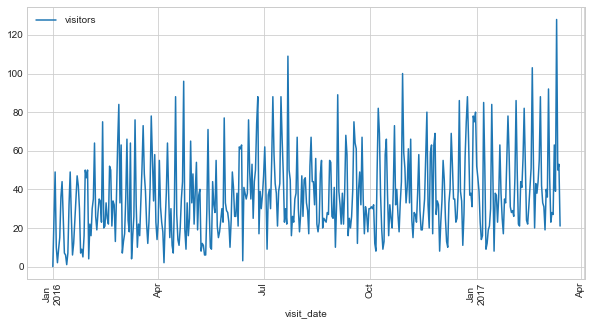

In [100]:
ax = train_data.plot(x='visit_date', y='visitors', figsize=(10,5), rot = 90)


### 差分とかをとる関数

In [101]:
def concat_diffs(data, key_column='visitors'):
    # 差分
    visitors_diff = data['visitors'].diff()
    visitors_diff.name = key_column + '_diff'

    # 変化率
    visitors_pct_change = data['visitors'].pct_change()
    visitors_pct_change.name = key_column + '_pct_change'

    # 対数差分
    visitors_log_diff = np.log(data['visitors']) - np.log(data['visitors'].shift(1))
    visitors_log_diff.name = key_column + '_log_diff'

    # まとめてreturn
    return pd.concat([data, visitors_diff, visitors_pct_change, visitors_log_diff], axis=1)
    


In [102]:
train_data_diffs = concat_diffs(train_data)
train_data_diffs.head()

C:\Users\hiroshi_kuriyama\AppData\Local\conda\conda\envs\recruit_py36\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


,visit_date,visitors,visitors_diff,visitors_pct_change,visitors_log_diff
0,2016-01-01,0.0,NaN,NaN,NaN
1,2016-01-02,24.0,24.0,inf,inf
2,2016-01-03,49.0,25.0,1.041667,0.713766
3,2016-01-04,10.0,-39.0,-0.795918,-1.589235
4,2016-01-05,2.0,-8.0,-0.800000,-1.609438


In [103]:
train_data_diffs_dropna = train_data_diffs.dropna(axis=0)
train_data_diffs_dropna.head()

,visit_date,visitors,visitors_diff,visitors_pct_change,visitors_log_diff
1,2016-01-02,24.0,24.0,inf,inf
2,2016-01-03,49.0,25.0,1.041667,0.713766
3,2016-01-04,10.0,-39.0,-0.795918,-1.589235
4,2016-01-05,2.0,-8.0,-0.800000,-1.609438
5,2016-01-06,9.0,7.0,3.500000,1.504077


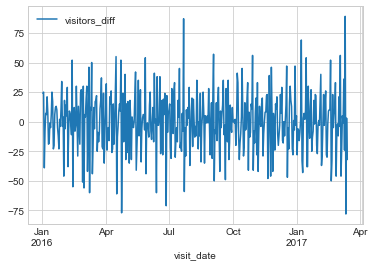

In [104]:
# 差分
train_data_diffs.plot(x='visit_date', y='visitors_diff')

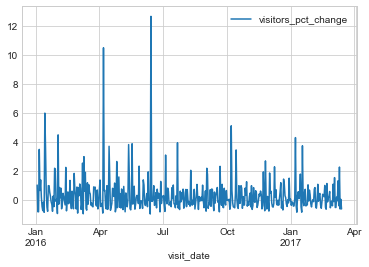

In [105]:
# 変化率
train_data_diffs.plot(x='visit_date', y='visitors_pct_change')

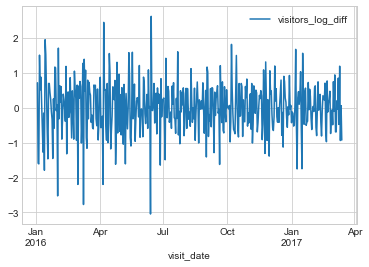

In [106]:
# 対数差分
train_data_diffs.plot(x='visit_date', y='visitors_log_diff')

## 自己相関のコレログラム

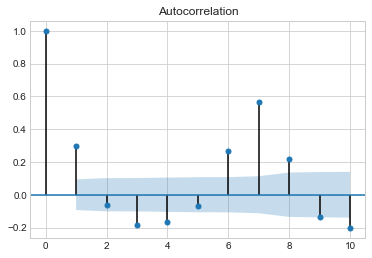

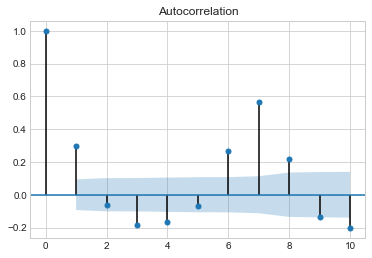

In [121]:

sm.graphics.tsa.plot_acf(train_data_diffs['visitors'], lags=10)

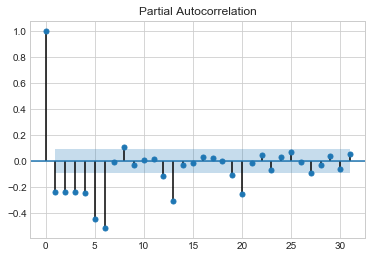

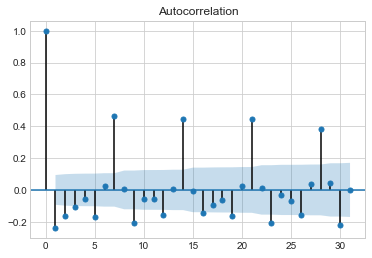

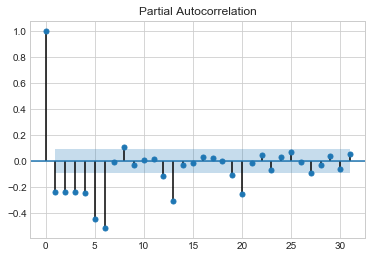

In [109]:
sm.graphics.tsa.plot_acf(train_data_diffs_dropna['visitors_diff'], lags=31)
sm.graphics.tsa.plot_pacf(train_data_diffs_dropna['visitors_diff'], lags=31)

C:\Users\hiroshi_kuriyama\AppData\Local\conda\conda\envs\recruit_py36\lib\site-packages\statsmodels\regression\linear_model.py:1263: RuntimeWarning: invalid value encountered in subtract
  X -= X.mean()                  # automatically demean's X


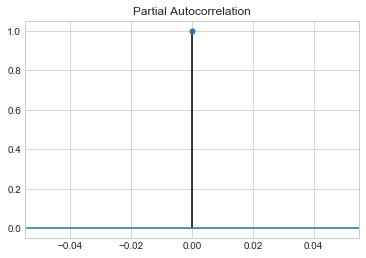

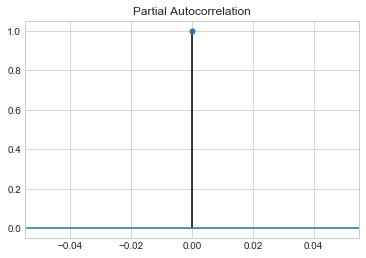

In [110]:
sm.graphics.tsa.plot_pacf(train_data_diffs_dropna['visitors_pct_change'], lags=31)

C:\Users\hiroshi_kuriyama\AppData\Local\conda\conda\envs\recruit_py36\lib\site-packages\statsmodels\regression\linear_model.py:1263: RuntimeWarning: invalid value encountered in subtract
  X -= X.mean()                  # automatically demean's X


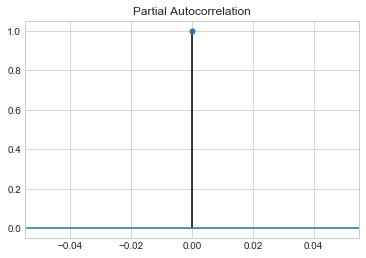

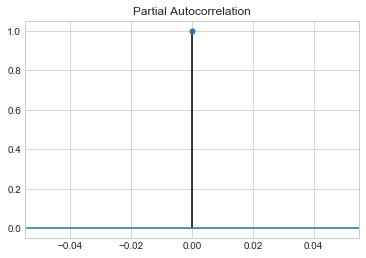

In [111]:
sm.graphics.tsa.plot_pacf(train_data_diffs_dropna['visitors_log_diff'], lags=31)

# 予測
### # とりあえARIMAは予測値が減衰していしまいうまくいかないので、ARMAモデルで予測

In [112]:
result = ARMA(train_data_diffs_dropna['visitors_diff'].values, order=(6,3), dates=train_data_diffs_dropna['visit_date']).fit()

C:\Users\hiroshi_kuriyama\AppData\Local\conda\conda\envs\recruit_py36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [113]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  438
Model:                     ARMA(6, 3)   Log Likelihood               -1852.740
Method:                       css-mle   S.D. of innovations             16.523
Date:                Fri, 22 Jun 2018   AIC                           3727.481
Time:                        18:21:19   BIC                           3772.385
Sample:                    01-02-2016   HQIC                          3745.199
                         - 03-14-2017                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0836      0.116      0.720      0.472      -0.144       0.311
ar.L1.y       -0.4200      0.065     -6.470      0.000      -0.547      -0.293
ar.L2.y       -1.0297      0.051    -20.236      0.000      -1.129      -0.930
ar.L3.y       -0.4157      0.084     -4.947      0.000      -0.580      -0.251
ar.L4.y       -0.5881      0.075     -7.864      0.000      -0.735      -0.441
ar.L5.y       -0.5732      0.051    -11.299      0.000      -0.673      -0.474
ar.L6.y       -0.3589      0.058     -6.166      0.000      -0.473      -0.245
ma.L1.y       -0.3050      0.060     -5.120      0.000      -0.422      -0.188
ma.L2.y        0.6151      0.035     17.518      0.000       0.546       0.684
ma.L3.y       -0.6722      0.071     -9.425      0.000      -0.812      -0.532
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6746           -0.8694j            1.1004           -0.1450
AR.2            0.6746           +0.8694j            1.1004            0.1450
AR.3           -0.2214           -0.9779j            1.0027           -0.2854
AR.4           -0.2214           +0.9779j            1.0027            0.2854
AR.5           -1.2518           -0.8496j            1.5129           -0.4051
AR.6           -1.2518           +0.8496j            1.5129            0.4051
MA.1           -0.2292           -1.0152j            1.0407           -0.2853
MA.2           -0.2292           +1.0152j            1.0407            0.2853
MA.3            1.3734           -0.0000j            1.3734           -0.0000
-----------------------------------------------------------------------------
"""

In [114]:
predict = result.predict(start='2017-03-15', end='2017-04-22')

### テストデータの差分も作成

In [115]:
test_data_diffs = concat_diffs(test_data)
test_data_diffs.head()

,visit_date,visitors,visitors_diff,visitors_pct_change,visitors_log_diff
0,2017-03-15,12.0,NaN,NaN,NaN
1,2017-03-16,30.0,18.0,1.500000,0.916291
2,2017-03-17,54.0,24.0,0.800000,0.587787
3,2017-03-18,71.0,17.0,0.314815,0.273696
4,2017-03-19,88.0,17.0,0.239437,0.214657


In [116]:
test_data_diffs_dropna = test_data_diffs.dropna(axis=0)
test_data_diffs_dropna.head()

,visit_date,visitors,visitors_diff,visitors_pct_change,visitors_log_diff
1,2017-03-16,30.0,18.0,1.500000,0.916291
2,2017-03-17,54.0,24.0,0.800000,0.587787
3,2017-03-18,71.0,17.0,0.314815,0.273696
4,2017-03-19,88.0,17.0,0.239437,0.214657
5,2017-03-20,35.0,-53.0,-0.602273,-0.921989


Text(0,0.5,'Visitors')

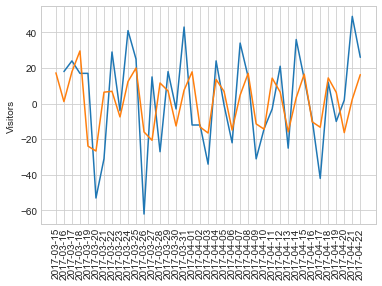

In [117]:
ax = plt.subplot()
ax.plot(test_data_diffs['visit_date'], test_data_diffs['visitors_diff'], label='Actual')
ax.plot(test_data_diffs['visit_date'], predict, label='Predict')
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('Visitors')

### 訓練データも含めたプロットを作る

In [118]:
# 3月の訓練データも含める
train_data_partial = train_data.query('visit_date >= "2017-03-01"')
test_data_large = pd.concat([train_data_partial, test_data]).reset_index()
test_data_large_diffs = concat_diffs(test_data_large)

In [119]:
predict_large = result.predict(start='2017-03-01', end='2017-04-22', dynamic=True)
predict_large[:15] = np.NAN

Text(0,0.5,'Visitors')

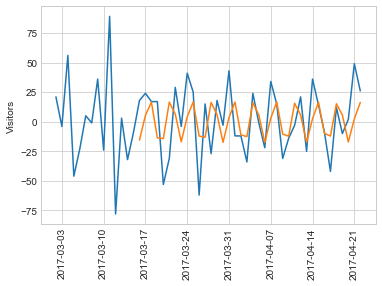

In [120]:
ax = plt.subplot()
ax.plot(test_data_large_diffs['visit_date'], test_data_large_diffs['visitors_diff'], label='Actual')
ax.plot(test_data_large_diffs['visit_date'], predict_large, label='Predict')
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('Visitors')